In [41]:
import pandas as pd
import numpy as np
import glob
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

In [42]:
import imblearn
from imblearn.over_sampling import SMOTE 

In [43]:
start_time = time.time()

In [44]:
asteroid_df = pd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df.drop(columns = ['diameter', 'albedo', 'a', 'i', 'neo'], inplace = True)
asteroid_df

,pha,H,e,q,n,moid,spkid,full_name
0,0,-7.411043,-0.608738,0.289176,-0.009788,0.306452,20000001,1 Ceres (A801 AA)
1,0,-6.932515,0.859223,-0.382876,-0.017945,-0.258065,20000002,2 Pallas (A802 FA)
2,0,-6.282209,1.108738,-0.618740,0.181077,-0.564516,20000003,3 Juno (A804 RA)
3,0,-7.466258,-0.503883,-0.357027,0.928222,-0.403226,20000004,4 Vesta (A807 FA)
4,0,-5.171779,0.440777,-0.444265,0.384992,-0.451613,20000005,5 Astraea (A845 XA)
...,...,...,...,...,...,...,...,...
137912,0,-3.141104,8.195146,6.101777,-3.502333,6.048387,3547316,(2010 BK118)
137913,0,-0.319018,7.751456,2.129241,-3.470979,2.258065,3516402,(2010 GW64)
137914,0,-1.306748,8.038835,4.859451,-3.497338,5.290323,3517549,(2010 GW147)
137915,0,-0.503067,7.960194,0.447496,-3.476215,0.903226,3523334,(2010 JH124)


## Split data

In [45]:
X = pd.DataFrame(asteroid_df['moid'])
y = asteroid_df.iloc[:, 0]

In [46]:
from sklearn.model_selection import train_test_split
X_train_original, X_test, y_train_original, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [47]:
sm = SMOTE(random_state = 42) 
X_train, y_train = sm.fit_resample(X_train_original, y_train_original.ravel())
  
print("After OverSampling, counts of label 'N': {}".format(sum(y_train == 0))) 
print("After OverSampling, counts of label 'Y': {}".format(sum(y_train == 1))) 

After OverSampling, counts of label 'N': 110091
After OverSampling, counts of label 'Y': 110091


In [48]:
X_train.shape, y_train.shape

((220182, 1), (220182,))

In [49]:
X_test.shape, y_test.shape

((27584, 1), (27584,))

## logistic regression model

In [50]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)    # Train the model using the training sets

LogisticRegression()

In [51]:
pd.DataFrame({"Accurancy on Train":[accuracy_score(y_train, logreg.predict(X_train))],
    "Accurancy on Test":[accuracy_score(y_test, logreg.predict(X_test))]})

,Accurancy on Train,Accurancy on Test
0,0.99802,0.995686


In [52]:
# Predict on the test data set
y_pred = logreg.predict(X_test)

In [53]:
logreg.predict(X_test)[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

#### Model slop and intercept

In [54]:
print("Number of coefficients:", len(logreg.coef_))
print("Estimated coefficients: {}".format(logreg.coef_))
print("Estimated intercept: {}".format(logreg.intercept_))

Number of coefficients: 1
Estimated coefficients: [[-23.21411911]]
Estimated intercept: [-45.4750117]


### Evaluate logistic regression model

In [55]:
target_names = ['non-PHA', 'PHA']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     non-PHA       1.00      1.00      1.00     27511
         PHA       0.38      1.00      0.55        73

    accuracy                           1.00     27584
   macro avg       0.69      1.00      0.77     27584
weighted avg       1.00      1.00      1.00     27584



In [56]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[27392,   119],
       [    0,    73]], dtype=int64)

#### RMS

In [57]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE value : {:.2f}".format(rmse))

RMSE value : 0.07


#### Model slop and intercept

#### R2

In [58]:
from sklearn.metrics import r2_score
print("R2 Score value: {:.2f}".format(r2_score(y_test, y_pred)))

R2 Score value: -0.63


In [59]:
# Evaluating training set performance

print("Training set score: {:.2f}".format(logreg.score(X_train, y_train)))

Training set score: 1.00


In [60]:
# Evaluating test set performance

print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 1.00


### Plotting Residual Error

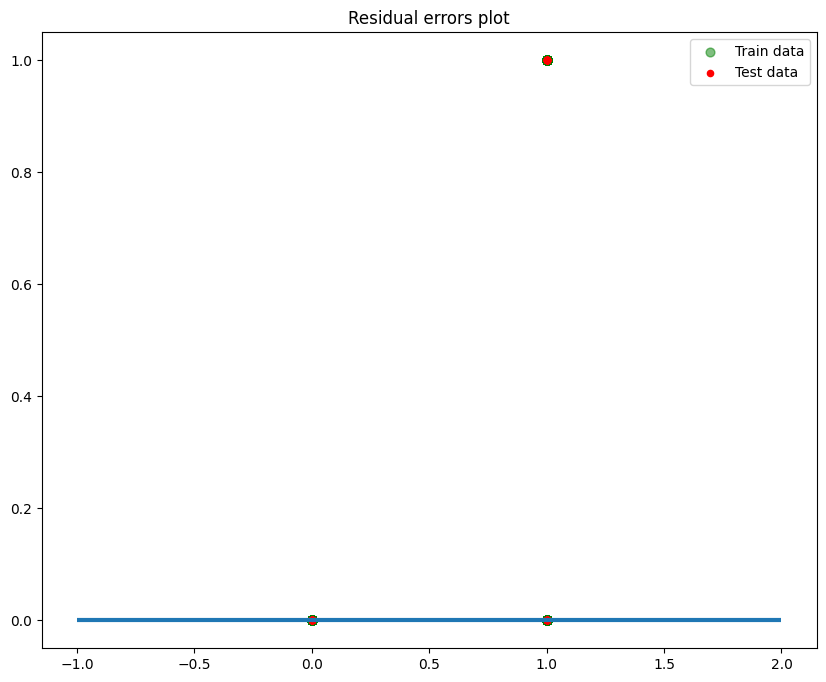

In [61]:
%matplotlib inline
plt.figure(figsize=(10,8))

# plotting residual errors in training data
plt.scatter(logreg.predict(X_train), logreg.predict(X_train) - y_train, c = 'g', s = 40, label = 'Train data', alpha = 0.5)

# plotting residual errors in test data
plt.scatter(logreg.predict(X_test), logreg.predict(X_test) - y_test, c = 'r', s = 20, label = 'Test data')

# plotting line for zero residual error
plt.hlines(y = 0, xmin = -1, xmax = 2, linewidth = 3)

# plotting legend
plt.legend(loc = 'upper right')

# plot title
plt.title("Residual errors plot")

# function to show plot
plt.show()

In [62]:
precision_metric_macro = precision_score(y_test, y_pred, average = "macro")
recall_metric_macro = recall_score(y_test, y_pred, average = "macro")
accuracy_metric = accuracy_score(y_test, y_pred)
f1_metric_macro = f1_score(y_test, y_pred, average = "macro")
    
print('Precision metric:',round(precision_metric_macro, 2))
print('Recall Metric:',round(recall_metric_macro, 2))
print('Accuracy Metric:',round(accuracy_metric, 4))
print('F1 score:',round(f1_metric_macro, 2))

Precision metric: 0.69
Recall Metric: 1.0
Accuracy Metric: 0.9957
F1 score: 0.77


In [63]:
precision_metric_micro = precision_score(y_test, y_pred, average = "micro")
recall_metric_micro = recall_score(y_test, y_pred, average = "micro")
f1_metric_micro = f1_score(y_test, y_pred, average = "micro")
    
print('Precision metric:',round(precision_metric_micro, 2))
print('Recall Metric:',round(recall_metric_micro, 2))
print('F1 score:',round(f1_metric_micro, 2))

Precision metric: 1.0
Recall Metric: 1.0
F1 score: 1.0


In [64]:
precision_metric_weighted = precision_score(y_test, y_pred, average = "weighted")
recall_metric_weighted = recall_score(y_test, y_pred, average = "weighted")
f1_metric_weighted = f1_score(y_test, y_pred, average = "weighted")
    
print('Precision metric:',round(precision_metric_weighted, 2))
print('Recall Metric:',round(recall_metric_weighted, 2))
print('F1 score:',round(f1_metric_weighted, 2))

Precision metric: 1.0
Recall Metric: 1.0
F1 score: 1.0


### Q-Q Plot

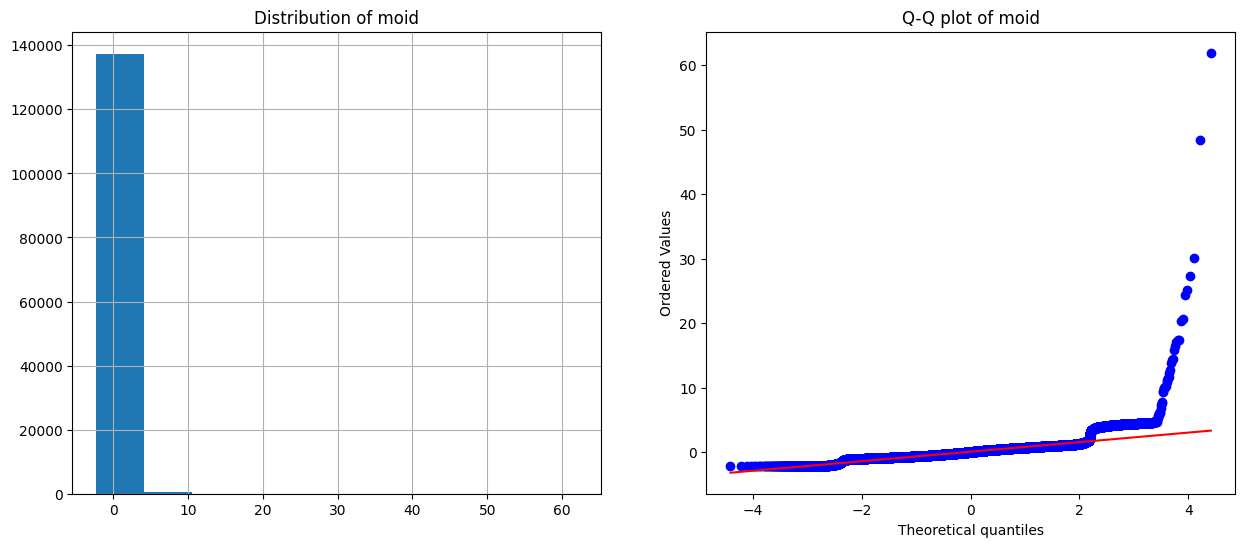

In [65]:
import pylab 
import scipy.stats as stats
       
plt.figure(figsize=(15, 6))

# Histogram of the variable
plt.subplot(1, 2, 1)
asteroid_df['moid'].hist()
plt.title('Distribution of moid')

# Q-Q plot for normality
plt.subplot(1, 2, 2)
stats.probplot(asteroid_df['moid'], dist="norm", plot=pylab)
plt.title('Q-Q plot of moid')
plt.show()

## Validation in Practice: Grid Search

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l2', 'elasticnet'],  # Regularization penalty types
    'C': [ 1, 10, 20],  # Regularization strength (inverse)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Solvers for optimization
    'max_iter': [300, 500],  # Maximum number of iterations for convergence
    'l1_ratio': [0, 0.5, 1]  # Only used with 'elasticnet' penalty
}

# Initialize logistic regression model
logreg = LogisticRegression()

# Initialize GridSearchCV with logistic regression and the parameter grid
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 5, n_jobs = -2)

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-2,
             param_grid={'C': [1, 10, 20], 'l1_ratio': [0, 0.5, 1],
                         'max_iter': [300, 500],
                         'penalty': ['l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             scoring='accuracy', verbose=5)

In [69]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 20, 'l1_ratio': 0, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.9987146993273661


In [70]:
logreg_best = LogisticRegression(penalty = 'l2', C = 20, max_iter =  300, solver = 'lbfgs')

## Heatmap for Hyperparameter Grid Search Results

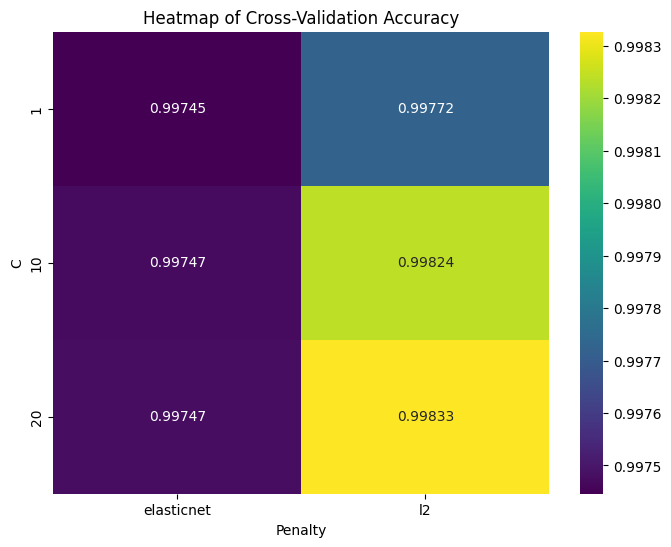

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming grid_search.cv_results_ is available after running GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
grouped_results = results.groupby(["param_C", "param_penalty"])["mean_test_score"].mean().reset_index()

# Pivot to create the scores matrix
scores_matrix = grouped_results.pivot(index="param_C", columns="param_penalty", values="mean_test_score")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".5f", cmap="viridis")
plt.title("Heatmap of Cross-Validation Accuracy")
plt.xlabel("Penalty")
plt.ylabel("C")
plt.show()


## Validation Curve (for a Single Hyperparameter)

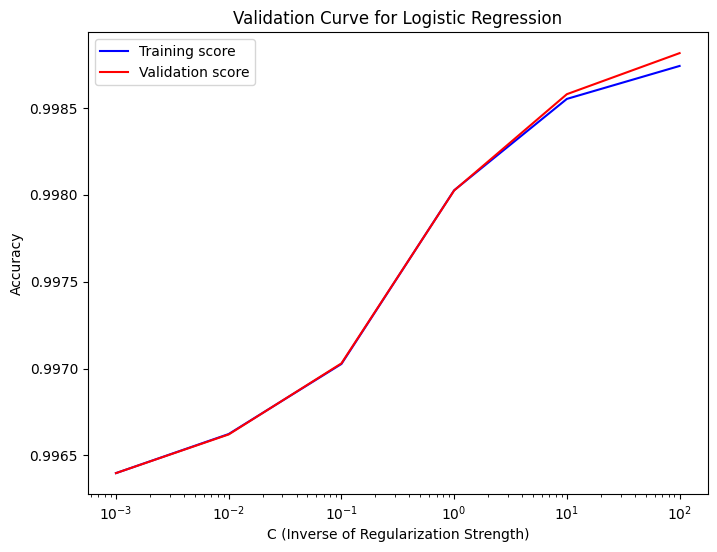

In [72]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, val_scores = validation_curve(
    LogisticRegression(),
    X_train, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label="Training score", color="blue")
plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation score", color="red")
plt.xlabel("C (Inverse of Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for Logistic Regression")
plt.xscale("log")  # Log scale for C
plt.legend()
plt.show()

## Learning Curves (Training vs. Cross-Validation Performance)

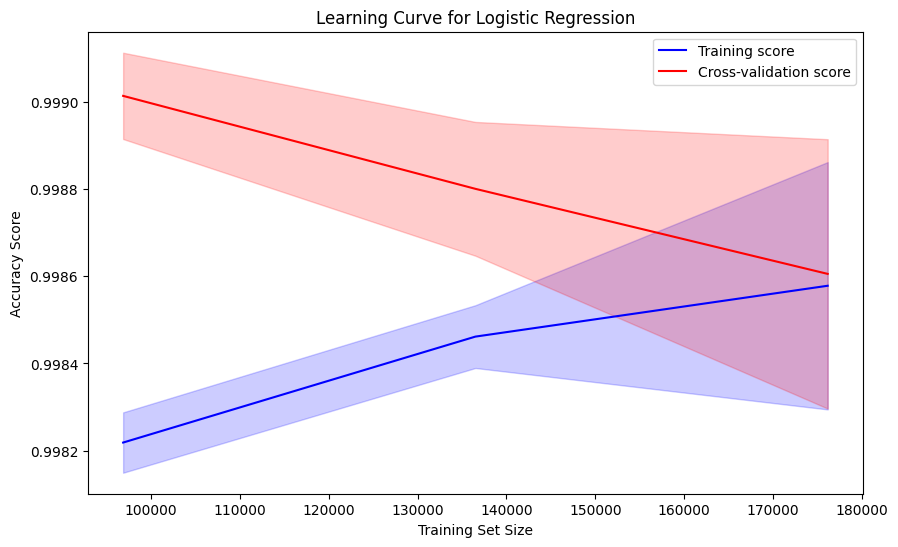

In [73]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    logreg_best, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
)

# Mean and standard deviation for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="red", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve for Logistic Regression")
plt.legend()
plt.show()

### Model validation via cross-validation

In [74]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

sm = SMOTE(random_state = 42) 
X1, y1 = sm.fit_resample(X1, y1.ravel())
X2, y2 = sm.fit_resample(X2, y2.ravel())

# fit the model on one set of data
logreg.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = logreg.predict(X2)
accuracy_score(y2, y2_model)

0.9973258534742104

In [75]:
y2_model = logreg.fit(X1, y1).predict(X2)
y1_model = logreg.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.9980521840250018, 0.9973258534742104)

In [76]:
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=5)

array([0.99771607, 0.99771607, 0.99771598, 0.99771598, 0.97389697])

In [77]:
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE
pipeline = Pipeline([
    ('smote', SMOTE()),                  # Step 1: Apply SMOTE
    ('logreg', LogisticRegression())     # Step 2: Logistic Regression model
])

# Perform cross-validation with SMOTE applied to each training fold
scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [1.         1.         1.         1.         0.96584853]
Mean accuracy: 0.99316970597832


In [78]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=skf)

print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.99634584 0.9963456  0.99660663 0.99601932 0.995432   0.99614983
 0.99673714 0.99575829 0.99595406]
Mean accuracy: 0.9961498568270533


## Cross Validation without KFold

In [79]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)  
scores = cross_val_score(pipeline, X, y, cv=kf)

print("Cross-validation scores with SMOTE:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores with SMOTE: [0.9956859  0.99586717 0.99648334 0.99641083 0.99597578]
Mean accuracy: 0.996084606075668


In [80]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")
#n_jobs = 1: Execution time: 1137.90 seconds
#n_jobs = -2: Execution time: 559.49 seconds

Execution time: 559.49 seconds
